In [1]:
import gym
import tensorflow as tf
import numpy as np
from collections import defaultdict

In [93]:
class Agent(object):
    def __init__(self, num_actions, state_encoder=None, gamma=1, alpha=1e-1):
        # values is a dictionary mapping state -> estimated reward for each action
        self.num_actions = num_actions
        self.gamma = gamma
        self.alpha = alpha
        self.state_encoder = state_encoder
        self.values = defaultdict(lambda: np.zeros(num_actions))
    
    def choose_action(self, state, epsilon=0):
        '''
        Chooses an action according to an epsilon-greedy strategy.
        epsilon=0 corresponds to a pure greedy strategy
        epsilon=1 corresponds to a pure random strategy
        
        Arguments:
            state: a structure representing the environments state
            epsilon: a number between 0 and 1 inclusive
        
        Returns:
            action: an integer representing the action
            reward: the predicted reward
        '''
        if self.state_encoder is not None:
            state = self.state_encoder.encode_state(state)
        if state in self.values:
            best = np.argmax(self.values[state])
            if epsilon == 0:
                return best, self.values[state][best]
            probs = np.ones(self.num_actions, dtype=np.float32) * epsilon / self.num_actions
            probs[best] += 1 - epsilon
        else:
            probs = np.ones(self.num_actions, dtype=np.float32) / float(self.num_actions)
        action = np.random.choice(self.num_actions, p=probs)
        return action, self.values[state][action]
    
    def step(self, state, action, reward, next_state):
        if self.state_encoder is not None:
            state = self.state_encoder.encode_state(state)
            next_state = self.state_encoder.encode_state(next_state)
        next_action, _ = self.choose_action(next_state, epsilon=0)
        true_value = reward + self.gamma * self.values[next_state][next_action]
        error = true_value - self.values[state][action]
        self.values[state][action] += self.alpha * error
        return error
        

class Discretizer(object):
    def __init__(self, env, num_buckets, num_sample_episodes=1000):
        self.env = env
        samples = []
        for i in range(num_sample_episodes):
            state = env.reset()
            samples.append(state)
            done = False
            while not done:
                state, reward, done, info = env.step(np.random.choice(env.action_space.n))
                samples.append(state)
        samples = np.array(samples)
        self.low = np.min(samples, axis=0)
        self.high = np.max(samples, axis=0)
        self.range = self.high - self.low
        self.n = num_buckets

    def encode_state(self, state):
        '''Encode state takes in an environments state and returns a tuple.'''
        d = np.round((state - self.low) / self.range * self.n).astype(np.int32)
        return tuple(np.clip(d, 0, self.n))
    

def train(env, agent, num_episodes):
    batch_error = []
    batch_steps = []
    batch_rewards = []
    for i in range(num_episodes):
        epsilon = np.exp((-1e-4)*i)
        state = env.reset()
        errors = list()
        steps = 1
        total_reward = 0
        while True:
            action, pred_reward = agent.choose_action(state, epsilon=epsilon)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            error = agent.step(state, action, reward, next_state)
#             errors.append(error**2)
            errors.append(error)
            steps += 1
            state = next_state
            if done:
                break
        batch_error.append(np.mean(errors))
        batch_steps.append(steps)
        batch_rewards.append(total_reward)
        if i % 100 == 0:
            print("Error: %.2f\tReward: %.2f\tSteps: %d" % (np.mean(batch_error), np.mean(batch_rewards), np.mean(batch_steps)))
            batch_error = []
            batch_steps = []
            batch_rewards = []

def play(env, agent):
    state = env.reset()
    env.render()
    done = False
    errors = []
    rewards = []
    steps = 0
    while not done:
        # use greedy strategy
        action, pred_reward = agent.choose_action(state, epsilon=0)
        state, reward, done, info = env.step(action)
        errors.append(reward - pred_reward)
        rewards.append(reward)
        steps += 1
        env.render()
    env.close()
    return sum(rewards), steps, np.mean(np.array(errors)**2)

In [94]:
# env = gym.make('CartPole-v0')
# env = gym.make("FrozenLake-v0")
env = gym.make("Blackjack-v0")
# discretizer = Discretizer(env, 20, num_sample_episodes=1)
# agent = Agent(env.action_space.n, state_encoder=discretizer, gamma=0.9, alpha=1e-1)
agent = Agent(env.action_space.n, state_encoder=None, gamma=0.9, alpha=1e-1)

In [91]:
env.reset()

(20, 3, False)

In [86]:
env.step(1)

((14, 10, False), 0, False, {})

In [92]:
env.step(0)

((20, 3, False), 1.0, True, {})

In [96]:
train(env, agent, 10000)

Error: 0.94	Reward: 1.00	Steps: 2
Error: 0.21	Reward: -0.46	Steps: 2
Error: 0.04	Reward: -0.42	Steps: 2
Error: -0.06	Reward: -0.44	Steps: 2
Error: 0.11	Reward: -0.37	Steps: 2
Error: 0.08	Reward: -0.44	Steps: 2
Error: 0.02	Reward: -0.49	Steps: 2
Error: 0.06	Reward: -0.38	Steps: 2
Error: 0.31	Reward: -0.17	Steps: 2
Error: 0.13	Reward: -0.25	Steps: 2
Error: -0.17	Reward: -0.51	Steps: 2
Error: 0.01	Reward: -0.43	Steps: 2
Error: 0.03	Reward: -0.28	Steps: 2
Error: 0.10	Reward: -0.17	Steps: 2
Error: 0.13	Reward: -0.37	Steps: 2
Error: 0.04	Reward: -0.36	Steps: 2
Error: 0.02	Reward: -0.35	Steps: 2
Error: -0.02	Reward: -0.41	Steps: 2
Error: 0.10	Reward: -0.40	Steps: 2
Error: -0.07	Reward: -0.42	Steps: 2
Error: 0.12	Reward: -0.19	Steps: 2
Error: -0.02	Reward: -0.36	Steps: 2
Error: 0.05	Reward: -0.41	Steps: 2
Error: 0.06	Reward: -0.44	Steps: 2
Error: -0.08	Reward: -0.33	Steps: 2
Error: 0.10	Reward: -0.31	Steps: 2
Error: 0.04	Reward: -0.34	Steps: 2
Error: -0.13	Reward: -0.40	Steps: 2
Error: 0.05	Re

In [97]:
agent.values

defaultdict(<function __main__.Agent.__init__.<locals>.<lambda>>,
            {(4, 1, False): array([ 0.0920995 , -0.00945149]),
             (4, 2, False): array([-0.10299381, -0.01275961]),
             (4, 3, False): array([-0.06715233,  0.04678152]),
             (4, 4, False): array([-0.1       ,  0.12033467]),
             (4, 5, False): array([-0.07014533,  0.12836159]),
             (4, 6, False): array([-0.13736679,  0.01605304]),
             (4, 7, False): array([-0.08748076,  0.06554157]),
             (4, 8, False): array([-0.18811353,  0.25759342]),
             (4, 9, False): array([-0.3612007 , -0.04297884]),
             (4, 10, False): array([-0.27020605,  0.47139066]),
             (5, 1, False): array([-0.46381488, -0.24725844]),
             (5, 2, False): array([-0.26116886,  0.34172421]),
             (5, 3, False): array([ 0.10707211,  0.03290696]),
             (5, 4, False): array([ 0.53610664,  0.15522373]),
             (5, 5, False): array([-0.09571553,  0.

In [98]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

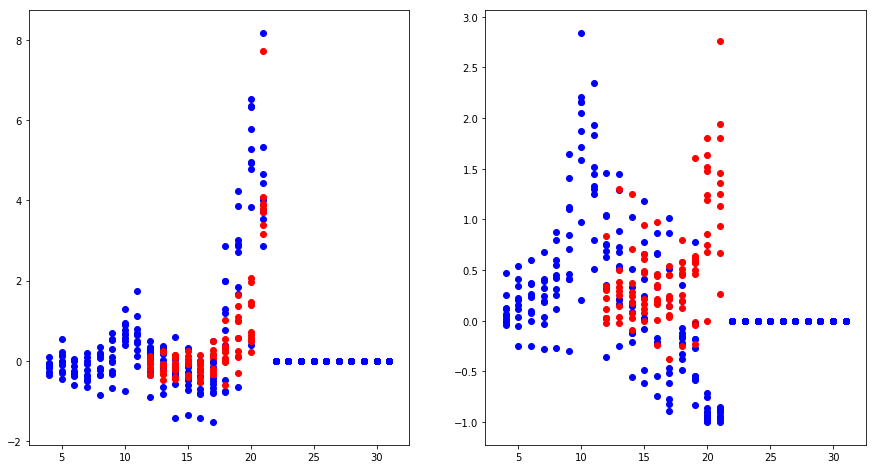

In [109]:
fig = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
for state, value in agent.values.items():
    c = 'red' if state[2] else 'blue'
    ax.scatter(state[0], value[0], c=c)
ax = plt.subplot(1, 2, 2)
for state, value in agent.values.items():
    c = 'red' if state[2] else 'blue'
    ax.scatter(state[0], value[1], c=c)
plt.show()

In [75]:
# env = gym.make('CartPole-v0')
# env = gym.make("FrozenLake-v0")
env = gym.make("Blackjack-v0")
play(env, agent)

NotImplementedError: 

In [ ]:
num_episodes = 10

Q = Net()
sess = tf.Session()
for i in range(num_episodes):
    state = env.reset()
    print(state)
    while True:
        predicted_reward, action = sess.run((Q.predicted_reward, Q.action), feed_dict={
            Q.input: state,
        })
        next_state, reward, done, info = env.step(action)
        discounted_reward, next_action = sess.run((Q.predicted_reward, Q.action), feed_dict={
            Q.input: next_state,
        })
        error, _ = sess.run((Q.error, Q.opt), feed_dict={
            Q.input: state,
            Q.discounted_reward: discounted_reward[0],
        })
        state = next_state
        if done:
            break

In [23]:
class Net(object):
    def __init__(self, gamma=0.9):
        self.input = tf.placeholder(tf.float32, shape=(None, 4), name='input_state')
        self.layer0 = tf.layers.dense(self.input, 4, activation=tf.sigmoid, kernel_initializer=tf.truncated_normal_initializer(stddev=1e-1))
        self.layer1 = tf.layers.dense(self.layer0, 4, activation=tf.sigmoid, kernel_initializer=tf.truncated_normal_initializer(stddev=1e-1))
        self.predicted_reward = tf.layers.dense(self.layer1, 2, activation=None, kernel_initializer=tf.truncated_normal_initializer(stddev=1e-1))

        # sample an action
        self.action = tf.cast(tf.multinomial(self.predicted_reward, 1), tf.int32)[0]
        
        self.gamma = tf.constant(gamma)
        self.reward = tf.placeholder(tf.float32, shape=(None), name='reward')
        self.mask = tf.zeros_like(self.reward)
        self.mask[self.action] += 1
        self.masked_reward = tf.dot(self.mask, self.reward)
        self.discounted_reward = tf.placeholder(tf.float32, shape=(None), name='discounted_reward')
        self.error = (self.masked_reward + self.gamma * self.discounted_reward - self.predicted_reward) * self.input
        self.opt = tf.train.AdamOptimizer().minimize(self.error)

In [28]:
num_episodes = 10

Q = Net()
sess = tf.Session()
for i in range(num_episodes):
    state = env.reset()
    print(state)
    while True:
        predicted_reward, action = sess.run((Q.predicted_reward, Q.action), feed_dict={
            Q.input: state,
        })
        next_state, reward, done, info = env.step(action)
        discounted_reward, next_action = sess.run((Q.predicted_reward, Q.action), feed_dict={
            Q.input: next_state,
        })
        error, _ = sess.run((Q.error, Q.opt), feed_dict={
            Q.input: state,
            Q.discounted_reward: discounted_reward[0],
        })
        state = next_state
        if done:
            break

ValueError: Shape must be rank 1 but is rank 2 for 'strided_slice_8' (op: 'StridedSlice') with input shapes: ?, [1,1], [1,1], [1].